# Cake Classification
## Machine Learning Course Project
---
### Author: Andrea Alberti  
### Date: May 2023
---
## Data: 
The data set contains 120 images for each of 15 kinds of cake. For each class 100 images
are in the training set and 20 form the test set. All the images have been resized to
224 × 224 pixels.

## Goal:
Build classifiers for the classification of images of cakes.

---

In [ ]:
import CC_functions as ccf
import numpy as np
import matplotlib.pyplot as plt
import os
import image_features
import pvml
import pandas as pd

### 1.1 LOW LEVEL FEATURES
##### Write a script that computes one of the low-level feature vector implemented in the image_features.py file. Train a classifier and evaluate the test accuracy.

In [ ]:
#EXTRACT LOW-LEVEL FEATURES (COLOR HISTOGRAMS) FROM IMAGES
classes = os.listdir("Data_gitignore/cake-classification/test")

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='CH')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CH_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='CH')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CH_train.txt.gz", data)

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES
data = np.loadtxt("Features/CH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_test.txt.gz")
Xtest = data[:, :-1]
Ytest = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, Xtest, Ytest, epochs, batch_size, model_name = 'ch_mlp', filename = 'ch_accs',store_model=True, store_accs = True)

In [ ]:
df_accs = pd.read_csv('Results/CH_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epoch', ylabel = 'Accuracy (%)')

### 1.2 NEURAL FEATURES
##### Use the pretrained PVMLNet to extract as features the activations of the last hidden layer. Train a perceptron without hidden layers and evaluate the test accuracy.

In [ ]:
classes = os.listdir("Data_gitignore/cake-classification/test")
cnn = pvml.CNN.load("Trained_models/pvmlnet.npz")

X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/test", cnn, classes)
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/neural_test.txt.gz", data)


X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/train", cnn, classes)
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/neural_train.txt.gz", data)

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES
data = np.loadtxt("Features/neural_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'cnn_mlp', filename = 'cnn_accs',store_model=True, store_accs = True)

In [ ]:
df_accs = pd.read_csv('Results/cnn_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epoch', ylabel = 'Accuracy (%)')

### 1.3 TRANSFER LEARNING
##### Build a new network by replacing the last layer of PVMLNet with the weights of the trained perceptron.

In [ ]:
cnn = pvml.CNN.load('Trained_models/pvmlnet.npz')
mlp = pvml.MLP.load('Trained_models/cnn_mlp.npz')


cnn.weights[-1] = mlp.weights[0][None, None, :, :]
cnn.biases[-1] = mlp.biases[0]

cnn.save("Trained_models/cnn_transfer_gitignore.npz")

classes = os.listdir('Data_gitignore/cake-classification/test')
imagename = 'ice_cream/45200.jpg'

ccf.item_prediction(imagename, classes, cnn)



In [ ]:
data = np.loadtxt("Features/neural_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

classes = os.listdir("Data_gitignore/cake-classification/test")
path = "Data_gitignore/cake-classification/test"

cnn_transfer = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')
all_predictions = []
for klass_label, klass in enumerate(classes):
    image_files = os.listdir(path + "/" + klass)
    for imagename in image_files:
        image_path = path + "/" + klass + "/" + imagename
        image = plt.imread(image_path) / 255.0
        #print(image_path)
        prediction = cnn_transfer.inference(image[None, :, :, :])
        all_predictions.append(prediction)

predicted_labels = np.array([0] * 300)
for i in range(300):
    predicted_labels[i] = np.argmax(all_predictions[i][1])
test_acc = (predicted_labels==Y_test).mean()
print("Test accuracy: ", test_acc)

### 2.1 COMBINING FEATURES
##### Try different combinations of low-level features (concatenate two or more feature vectors with np.concatenate).

| FEATURES COMBINATION |
| --- |
| color histogram + edge direction |
| color histogram + co-occurrence matrix |
| edge direction + co-occurrence matrix |
| color histogram + + edge direction + co-occurrence matrix |


In [ ]:
#EXTRACT OTHERS LOW-LEVEL FEATURES FROM IMAGES
classes = os.listdir("Data_gitignore/cake-classification/test")

#EDGE DIRECTION HISTOGRAM
X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='EDH')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/EDH_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='EDH')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/EDH_train.txt.gz", data)


#COOCCURRENCE MATRIX
X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='CM')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CM_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='CM')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CM_train.txt.gz", data)


Load the different features

In [ ]:
feature_names = ['CH_test', 'CH_train', 'EDH_test', 'EDH_train', 'CM_test', 'CM_train']
features_list = ccf.load_features(feature_names)
X_CH_test, Y_CH_test, X_CH_train, Y_CH_train, X_EDH_test, Y_EDH_test, X_EDH_train, Y_EDH_train, X_CM_test, Y_CM_test, X_CM_train, Y_CM_train = features_list

Concatenate the features to get various combinations (listed in above table). Store the new features.

In [ ]:
#HISTOGRAM + EDGE DIRECTION HISTOGRAM
X_test_CH_EDH, X_train_CH_EDH = ccf.concatenate_features([X_CH_test, X_EDH_test], Y_CH_test, [X_CH_train, X_EDH_train], Y_CH_train, 'CH_EDH_test', 'CH_EDH_train', store = True)

#HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_CM, X_train_CH_CM = ccf.concatenate_features([X_CH_test, X_CM_test], Y_CH_test, [X_CH_train, X_CM_train], Y_CH_train, 'CH_CM_test', 'CH_CM_train', store = True)

#EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_EDH_CM, X_train_EDH_CM = ccf.concatenate_features([X_EDH_test, X_CM_test],  Y_CM_test, [X_EDH_train, X_CM_train], Y_CM_train, 'EDH_CM_test', 'EDH_CM_train', store = True)

#HISTOGRAM + EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_EDH_CM, X_train_CH_EDH_CM = ccf.concatenate_features([X_CH_test, X_EDH_test, X_CM_test], Y_CH_test, [X_CH_train, X_EDH_train, X_CM_train], Y_CH_train, 'CH_EDH_CM_test', 'CH_EDH_CM_train', store = True)


Load the stored combined features and train a classifier. Evaluate the test accuracy.

In [ ]:
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1

    mlp = pvml.MLP([X_train.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'{names[j]}_mlp', filename = f'{names[j]}_accs',store_model=True, store_accs = True)
    j += 1


Plot the results

Do the same but using features normalized with MEAN-VAR, MIN-MAX and WHITENING.

In [ ]:
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1
    
    #mean-var normalization
    X_train_norm, X_test_norm = ccf.mean_var_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_mvar_mlp', filename = f'{names[j]}_mvar_accs',store_model=True, store_accs = True)
    
    #min-max normalization
    X_train_norm, X_test_norm = ccf.min_max_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_minmax_mlp', filename = f'{names[j]}_minmax_accs',store_model=True, store_accs = True)
    
    #whitening normalization
    X_train_norm, X_test_norm = ccf.mean_var_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_white_mlp', filename = f'{names[j]}_white_accs',store_model=True, store_accs = True)
    j += 1
    
    

Plot the results

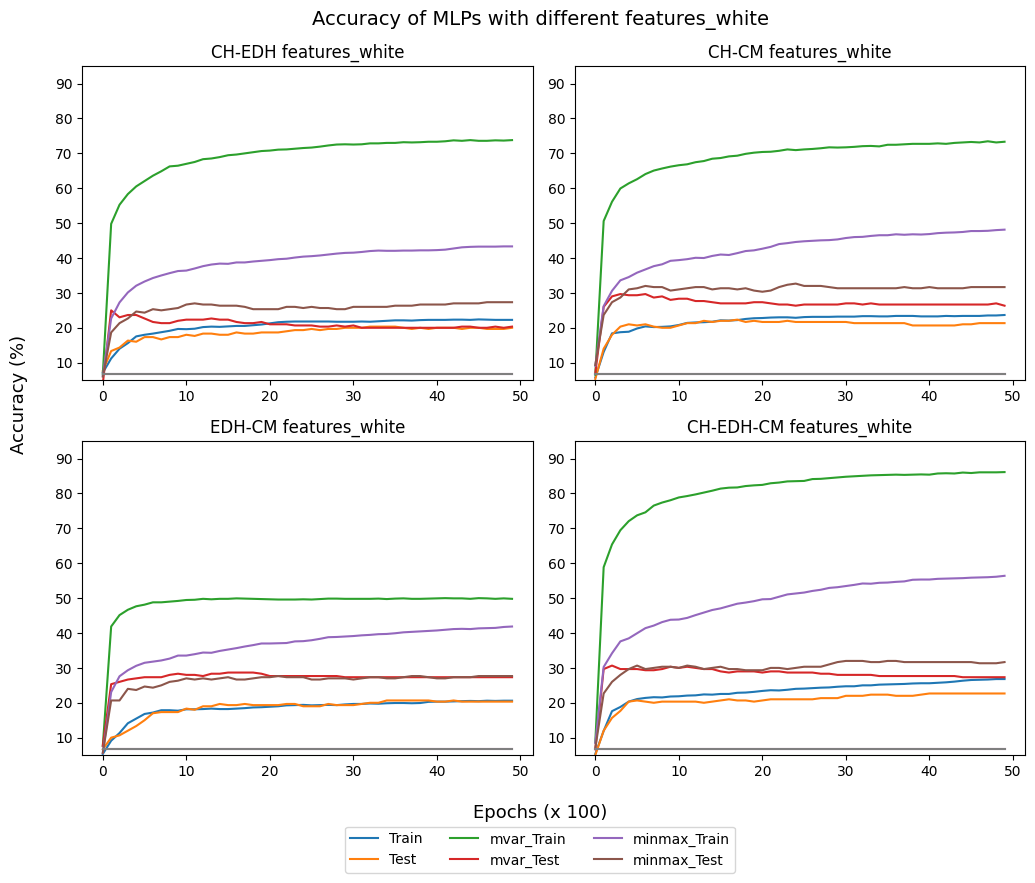

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

names = ['', '_mvar', '_minmax', '_white']
for name in names:
    
    #CH-EDH
    df_accs = pd.read_csv(f'Results/ch_edh{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-EDH features{name}', ax=axs[0], legend = False, xlabel='')
    axs[0].set_ylim([5, 95])

    #CH-CM
    df_accs = pd.read_csv(f'Results/ch_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-CM features{name}', ax=axs[1], legend=False,xlabel='')
    axs[1].set_ylim([5, 95])

    #EDH-CM
    df_accs = pd.read_csv(f'Results/edh_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'EDH-CM features{name}', ax=axs[2],  legend=False,xlabel='')
    axs[2].set_ylim([5, 95])

    #CH-EDH-CM
    df_accs = pd.read_csv(f'Results/ch_edh_cm{name}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'CH-EDH-CM features{name}', ax=axs[3], legend=False,xlabel='')
    axs[3].set_ylim([5, 95])

#title
fig.suptitle(f'Accuracy of MLPs with different features{name}', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test', 'mvar_Train', 'mvar_Test', 'minmax_Train', 'minmax_Test'], loc = 'center', bbox_to_anchor=(0.5, -0.07), ncol=3)
fig.tight_layout()

### 2.2 ANALYSIS
##### Identify the pairs of classes that are more likely to be confused with neural features. Also identify the test images that are misclassified even if the classifier predicted their label with high confidence.

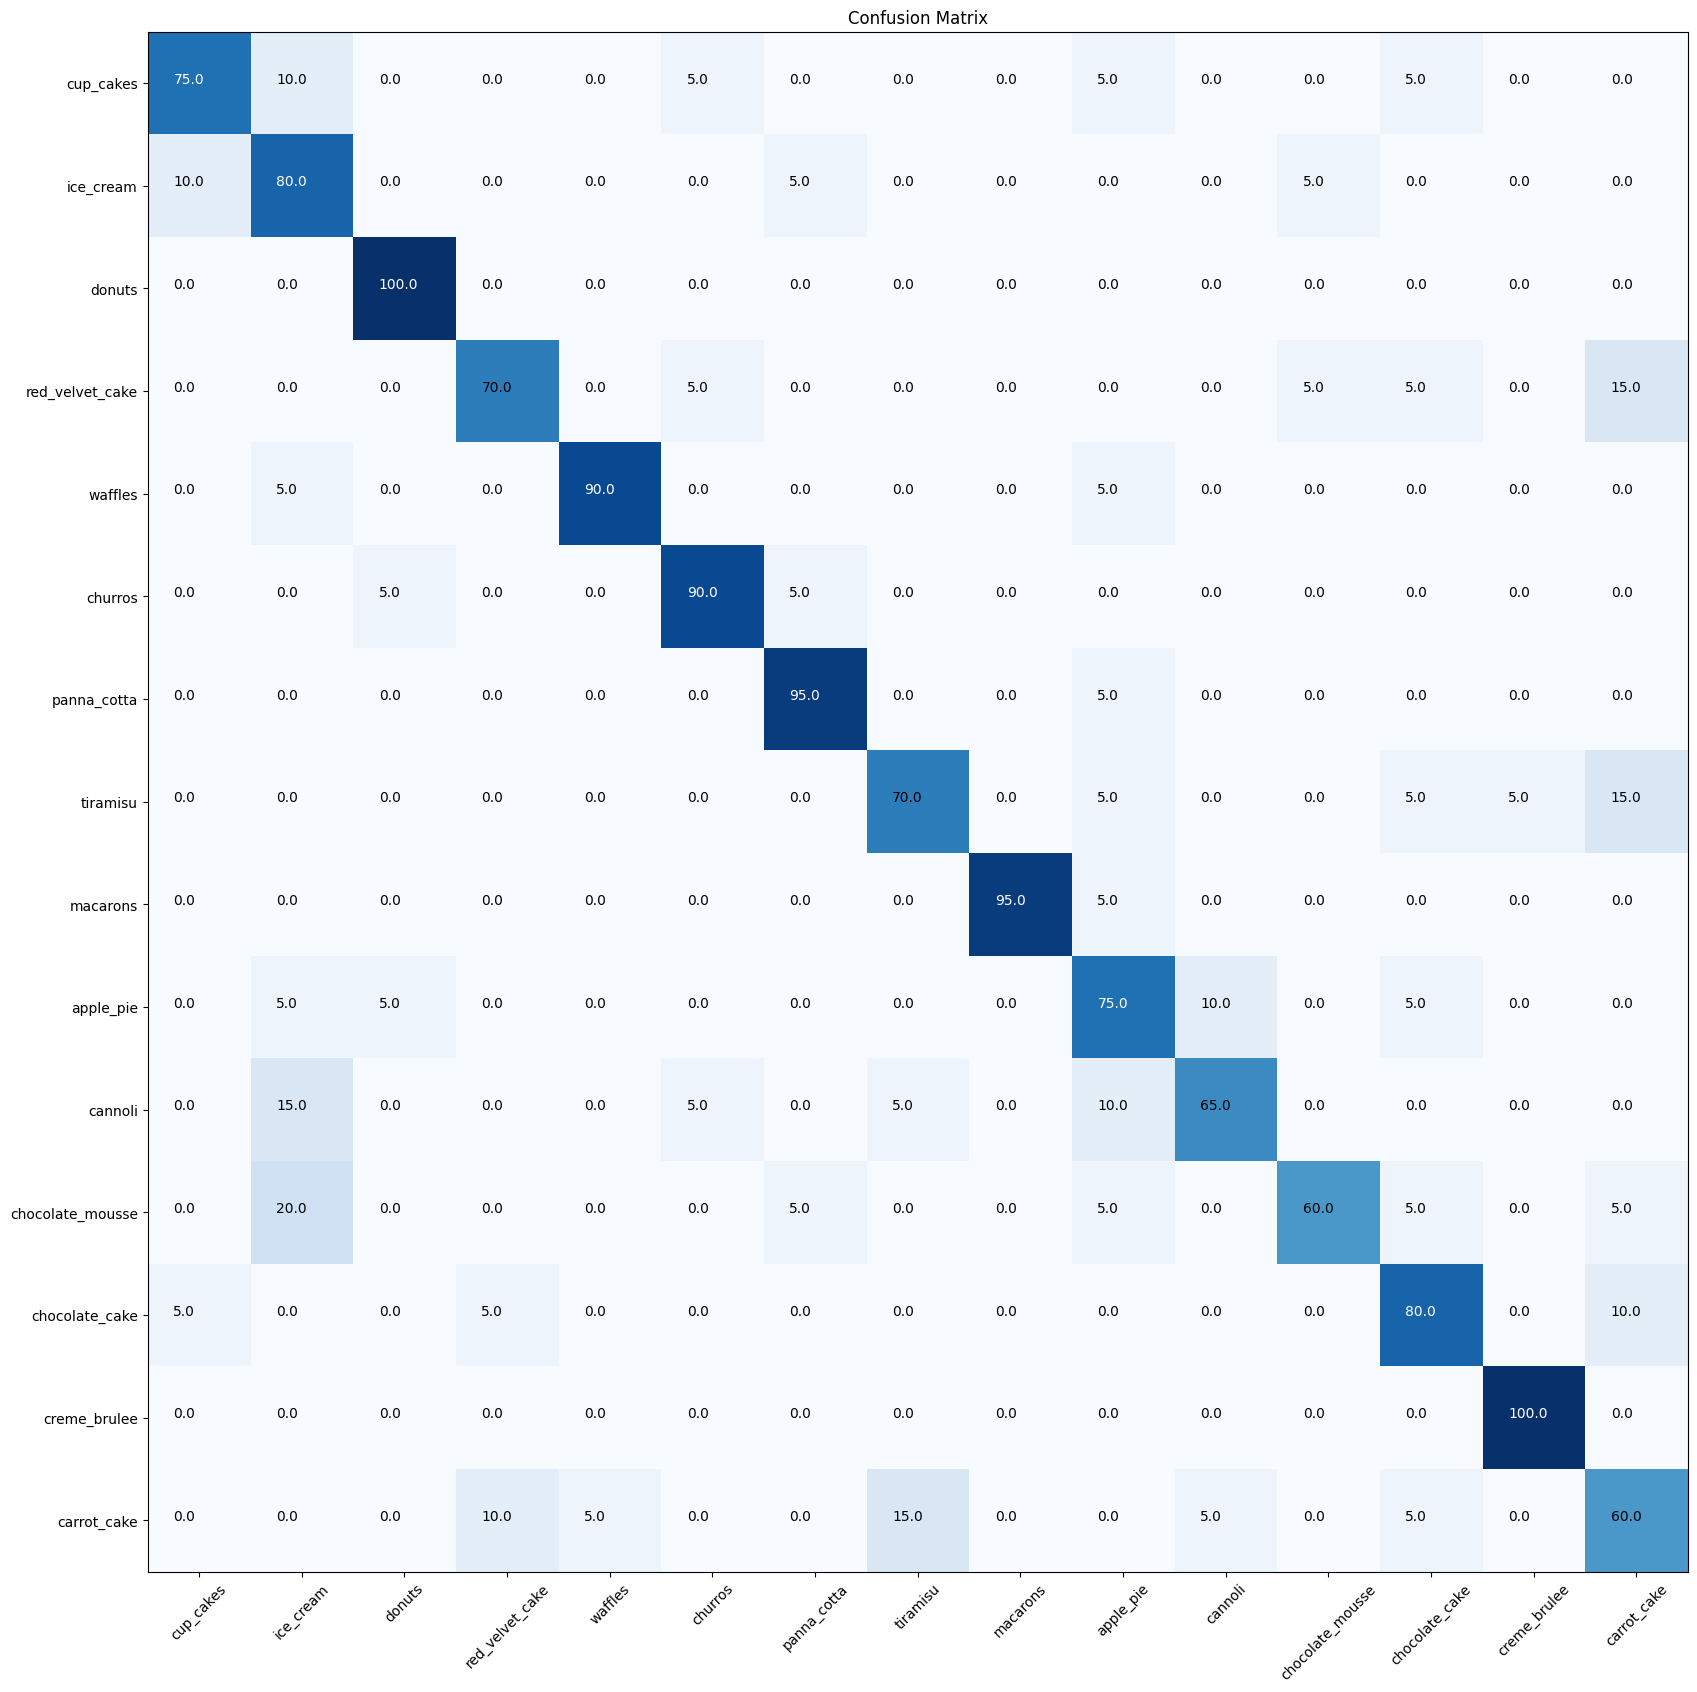

In [48]:
#analysis of the best model
classes = os.listdir('Data_gitignore/cake-classification/test')

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

mlp = pvml.MLP.load('Trained_models/cnn_mlp.npz')
predictions, probs = mlp.inference(X_test)

cm = ccf.confusion_matrix(Y_test, predictions, classes, show = True, rnorm = True)

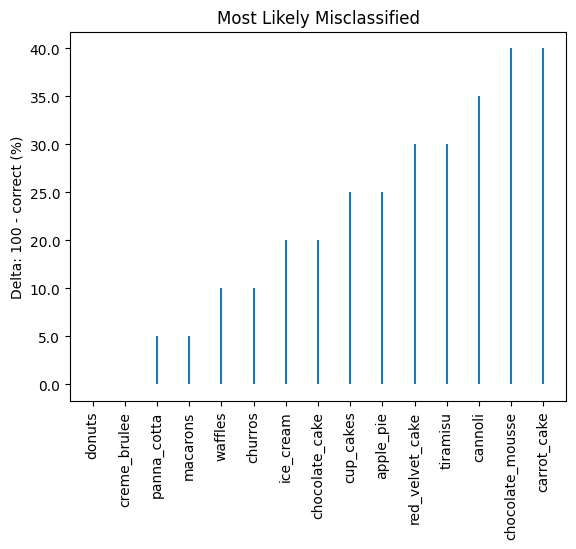

array([['donuts', 'creme_brulee', 'panna_cotta', 'macarons', 'waffles',
        'churros', 'ice_cream', 'chocolate_cake', 'cup_cakes',
        'apple_pie', 'red_velvet_cake', 'tiramisu', 'cannoli',
        'chocolate_mousse', 'carrot_cake'],
       ['0.0', '0.0', '5.0', '5.0', '10.0', '10.0', '20.0', '20.0',
        '25.0', '25.0', '30.0', '30.0', '35.0', '40.0', '40.0'],
       ['20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20',
        '20', '20', '20', '20']], dtype='<U32')

In [49]:
counters = np.bincount(Y_test)
classes = np.array(classes)
ccf.likely_misclassified(counters, cm, classes, 15, show = True)

the class 'cup_cakes' is frequently exchanged with 'ice_cream'
the class 'ice_cream' is frequently exchanged with 'cup_cakes'
the class 'donuts' is frequently exchanged with 'cup_cakes'
the class 'red_velvet_cake' is frequently exchanged with 'carrot_cake'
the class 'waffles' is frequently exchanged with 'ice_cream'
the class 'churros' is frequently exchanged with 'donuts'
the class 'panna_cotta' is frequently exchanged with 'apple_pie'
the class 'tiramisu' is frequently exchanged with 'carrot_cake'
the class 'macarons' is frequently exchanged with 'apple_pie'
the class 'apple_pie' is frequently exchanged with 'cannoli'
the class 'cannoli' is frequently exchanged with 'ice_cream'
the class 'chocolate_mousse' is frequently exchanged with 'ice_cream'
the class 'chocolate_cake' is frequently exchanged with 'carrot_cake'
the class 'creme_brulee' is frequently exchanged with 'cup_cakes'
the class 'carrot_cake' is frequently exchanged with 'tiramisu'


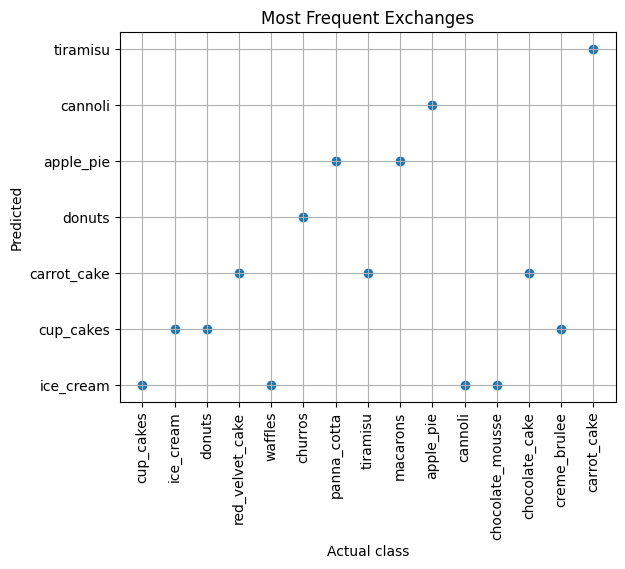

In [50]:
#print most frequet classes exchanges

wrong_labelled, wrong_valued = ccf.wrong_classes(cm, classes)
for j in range(15):
    print(f"the class '{wrong_labelled[0,j]}' is frequently exchanged with '{wrong_labelled[1,j]}'")

plt.figure()
plt.scatter(wrong_labelled[0,:], wrong_labelled[1,:])
plt.grid(True)
plt.xticks(rotation=90)
plt.title('Most Frequent Exchanges')
plt.xlabel('Actual class')
plt.ylabel('Predicted')
plt.show()

In [ ]:
misclassified_index = np.where(predictions != Y_test)
#class_correct = Y_test[misclassified_index]
class_correct = (misclassified_index[:][0] // 20) % 20
class_wrong= predictions[misclassified_index]
in_class_pos = misclassified_index - class_correct*20
class_names_correct = [classes[i] for i in class_correct]
class_names_wrong = [classes[i] for i in class_wrong]

#create an array of two rows. The first contains the class names, the second the positions of the images misclassified in the class
misclassified_info = np.array([class_names_correct, in_class_pos])

for name_correct, pos, name_wrong in zip(class_names_correct,in_class_pos[0],class_names_wrong):
    c = os.listdir('Data_gitignore/cake-classification/test/' + name_correct)
    print(f"image '{c[pos]}' of class {name_correct} is misclassified as {name_wrong}")

cnn = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')
c_list, p_list = ccf.item_prediction('cup_cakes/1703900.jpg', classes, cnn, show = True)


### 2.3 NEURAL FEATURES
##### Try to use neural features computed by different hidden layers. When the activations are spatially distributed, you may reduce them to a single feature vector by averaging over the spatial dimensions.

In [ ]:
#extract features

act_layer = -7 #specify the layer to extract features from

classes = os.listdir("Data_gitignore/cake-classification/test")
path = 'Data_gitignore/cake-classification/test/'
cnn = pvml.CNN.load("Trained_models/pvmlnet.npz")
f = ccf.extract_neural_features(plt.imread(path+'cup_cakes/1703900.jpg'), cnn, act_layer)


X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/test", cnn, classes, act_layer)
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt(f"Features/neural{act_layer}_test.txt.gz", data)


X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/train", cnn, classes, act_layer)
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt(f"Features/neural{act_layer}_train.txt.gz", data)

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES

act_layer = -7 #layer with respect to which we want to fit the MLP

data = np.loadtxt(f"Features/neural{act_layer}_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt(f"Features/neural{act_layer}_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'cnn{act_layer}_mlp', filename = f'cnn{act_layer}_accs',store_model=True, store_accs = True)

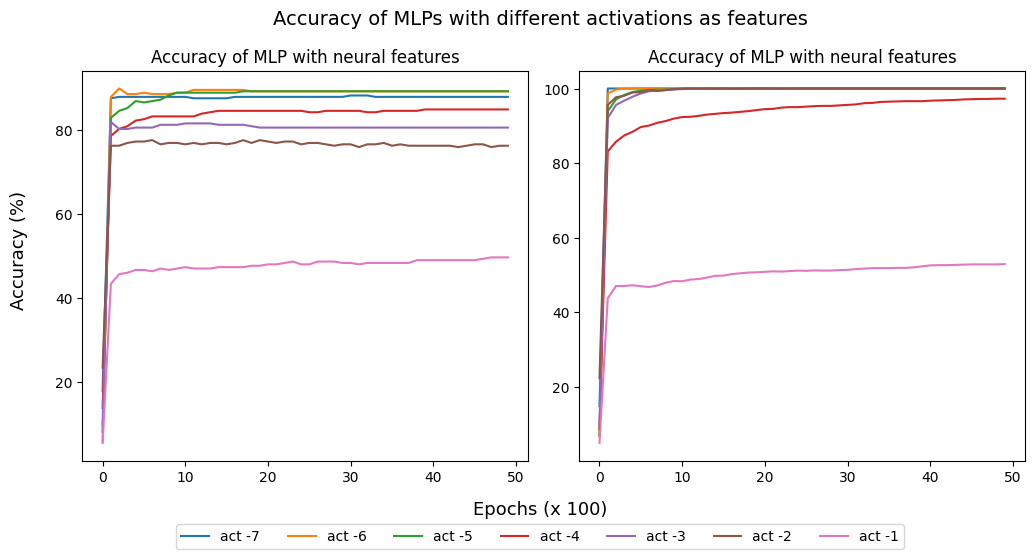

In [46]:
#plot the results relative to the different activations
act_layers = [-7, -6, -5, -4, -3, -2, -1]

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs = axs.flatten()

for act_layer in act_layers:
    df_accs = pd.read_csv(f'Results/cnn{act_layer}_accs.csv')
    df_accs.plot(x = 'epoch', y = 'test_acc', title = 'Accuracy of MLP with neural features', ax = axs[0], legend = False, xlabel = '')
    df_accs.plot(x = 'epoch', y = 'train_acc', title = 'Accuracy of MLP with neural features', ax = axs[1], legend = False, xlabel = '')
    
#title
fig.suptitle(f'Accuracy of MLPs with different activations as features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['act -7', 'act -6', 'act -5', 'act -4', 'act -3', 'act -2', 'act -1', ], loc = 'center', bbox_to_anchor=(0.5, -0.074), ncol=7)
fig.tight_layout()



## Future Work
### 2.4 FINE TUNING
##### Try to fine-tune the CNN after transfer learning (i.e. continue training with as very small learning rate like 10−5).